In [1]:
import pandas as pd

# Preparation: Load the data
The first step in the process of making an intent detection model is to load up the data.
We have a CSV file containing samples of things a person might say and which intent it belongs to.

You can read data files like the CSV file using pandas. Below you can find the code to do so.

In [2]:
df = pd.read_csv('data.csv')

## Dataset summary
Let's take a look at the dataset and see what it looks like.
We're primarily interested in the amount of samples available and the class balance.

### What's in the dataset
The dataset contains sentences a user might say and the intent that it should be classified to.
To get a sense of what's in the dataset, let's first print the `head()`.

In [3]:
df.head()

,text,intent
0,I need to hear the song Aspro Mavro from Bill ...,PlayMusic
1,play Yo Ho from the new york pops on Youtube,PlayMusic
2,Play some seventies music by Janne Puurtinen o...,PlayMusic
3,play the Música Da Série De Filmes O Hobbit al...,PlayMusic
4,Play Magic Sam from the thirties,PlayMusic


### Class balance
The value counts function shows you the number of records per unique value in a column.
As you can see below, we have about the same number of samples for each intent.

In [4]:
df['intent'].value_counts()

PlayMusic               2000
GetWeather              2000
BookRestaurant          1973
SearchScreeningEvent    1959
RateBook                1956
SearchCreativeWork      1954
Name: intent, dtype: int64

### Total number of records
Let's take a look at the total number of records in the dataset.
This should be the sum of all the classes.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11842 entries, 0 to 11841
Data columns (total 2 columns):
text      11842 non-null object
intent    11842 non-null object
dtypes: object(2)
memory usage: 185.1+ KB


The info method shows the total number of entries and the number of non-null entries.
They look the same, so we don't have any records without an intent label. 

Great, it looks like the data is usable for our purposes.

# Preparation: Exploratory data analysis
The next step is to perform uses exploratory data analysis techniques to get a sense of the data.
Later on we will be building a model that classifies sequences. This has some specific requirements:

 * The length of the sequences
 * The distribution of the word counts


### Obtaining information about sequence length
The problem with recurrent neural networks is that they are sensitive to the length of the sequences used to train the model.
If there's a large difference in length, you will end up with a network that doesn't train well.

Ideally the sentences should be equal in length or at least close enough.

To check if this is the case we need to visualize the distribution of the sequence lengths.

In [6]:
from nltk import word_tokenize
import matplotlib.pyplot as plt

Let's tokenize the sentences first and calculate the length of each resulting sequence of tokens.

In [7]:
tokenized_sentences = [word_tokenize(s.lower()) for s in df['text'].tolist()]
sequence_lengths = [len(s) for s in tokenized_sentences]

The visualization is easily done using matplotlib. The Y-axis displays the number of sequences of a given length. The X-axis displays the length of the sequences.

Notice that we group together the sequence lengths in buckets. So some resolution is lost. 
But it does give a good idea of what we're dealing with.

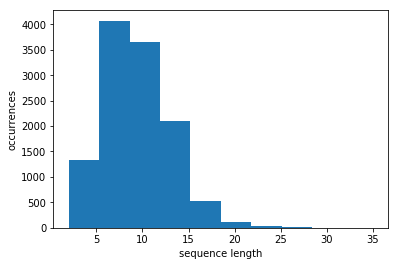

In [8]:
plt.hist(sequence_lengths)

plt.xlabel('sequence length')
plt.ylabel('occurrences')

plt.show()

### Obtaining information about the word distribution
The second problem that we have with our neural network is that the number of different words also influences the performance of the network. Typically you don't want any words that are generic in nature. But since we're classifying sequences you need enough information to maintain the relationship between different words in the sentence that are identifying for an intent.

The code below builds a list of word counts from all the tokenized sentences in the dataset.
This involves two loops, the first one iterates over all sentences, the second loop iterates over 
the words in each sentence. 

We build a dictionary that we than convert into a new dataframe. 

In [9]:
word_counts = {
    
}

for s in tokenized_sentences:
    for w in s:
        if not w in word_counts:
            word_counts[w] = 1
        else:
            word_counts[w] = word_counts[w] + 1
            
df_wordcount = pd.DataFrame.from_dict(word_counts, orient='index')
df_wordcount.columns = ['count']

To get a sense of the data, we are interested in frequently occurring terms first. This information is most easily obtained by sorting the data frame.

In [10]:
df_wordcount.sort_values(by=['count'], ascending=False).head(20)

,count
the,6723
a,4215
in,3275
for,3008
of,2451
i,2101
at,2097
.,2026
play,1904
to,1725


Looks like we need to remove stopwords from the dataset. For now, we're done exploring the data.
Let's build a model based on the data.

# Encode data
The neural network we've created only understands vectors of numbers. But we don't have any numbers in our data.
The fix is to encode the data into numbers. Also, we need to split the data in a train and test set.

### Split the data in a train and test set
We could train the model on all data. But we want to measure the effects of overfitting in our model.
So we split the dataset in two components. A training set and a test set. 

The test set will help us measure if we are overfitting and by how much.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['intent'])

### Encoding sentences into sequences of features
First we encode each sentence into a sequence of one-hot vectors.
For this we need to make a lookup table that maps a word to an index in the vector.
Then we encode all the values using this lookup table.

In [17]:
import numpy as np

In [18]:
sorted_wordcounts = sorted(word_counts.items(), key=lambda item: item[1])
sorted_wordcounts = reversed(sorted_wordcounts)

unique_words = [w for w,c in sorted_wordcounts]
unique_words = unique_words[:2500]

unique_words = ['UNK'] + unique_words

word2idx = dict(zip(unique_words, range(0,len(unique_words))))
idx2word = dict(zip(range(0, len(unique_words)), unique_words))

In [19]:
def one_hot(index, size):
    v = np.zeros(size)
    v[index] = 1.0
    
    return v

In [20]:
def word_index(word):
    if not word in word2idx:
        return 0
    else:
        return word2idx[w]

In [21]:
def encode_sequence(sentence):
    sequence = word_tokenize(sentence.lower())
    encoded_list = [one_hot(word_index(w), len(unique_words)) for w in sequence]
    
    return np.asarray(encoded_list).astype(np.float32)

In [22]:
feature_data = [encode_sequence(s) for s in df_train['text'].values]

### Encoding labels into vectors
The labels can be encoded into a one-hot vectors as well. But with a much simpler trick.
You can ask pandas to create dummy columns. What happens is the following.

 * A new column is created for every unique value in the columns that you want dummies for
 * All records are converted, by assigning a value to the dummy column that matches the value in the dummified column.

In [23]:
possible_intents = df['intent'].unique().tolist()
label2idx = dict(zip(possible_intents, range(len(possible_intents))))
idx2dlabel = dict(zip(range(len(possible_intents)), possible_intents))

In [24]:
def encode_label(label):
    return one_hot(label2idx[label], len(possible_intents))

In [25]:
label_data = [encode_label(label) for label in df_train['intent']]
label_data = np.asarray(label_data).astype(np.float32)

# Build a model
To detect the intents we're going to build a recurrent model. We're going to build our model using Microsoft Cognitive Toolkit an open source deep learning framework from Microsoft.

In [11]:
import cntk as C
from cntk.layers import Embedding, Sequential, LSTM, Dense, Recurrence, Dropout
from cntk import Trainer

The input size of the neural network is equal to the number of unique words in the dataset.
The output size of the neural network should be equal to the number of intents we understand.

We record these values below, so that they are easily accessed.

In [12]:
input_size = 2501 # Max words + 1 for unknown tokens

In [13]:
num_intents = len(df['intent'].astype('category').unique())

The model is made up out of an embedding layer, a recurrent layer of one LSTM unit and a dense layer for classification.
This is expressed as a function call to different layer types. Notice that we include a `C.sequence.last` layer. This ensures that the input of the `Dense` layer is the output of the last iteration for the `LSTM` layer.

In [14]:
model = Sequential([
    Embedding(300, name='embedding'), 
    Recurrence(LSTM(128, name='lstm'), name='recurrent'), 
    C.sequence.last, 
    Dropout(dropout_rate=0.5),
    Dense(64, activation=C.relu),
    Dense(num_intents, activation=C.softmax, name='output')])

# Train the model
Once you have a model setup, you can start to train it.
First we need to configure the model as a mathmatical function that we can optmize.
Next we need to make sure that we can feed input into the model in the right shape. This means we need to encode the sequences and labels into correct format.

To train the network we need to provide two input variables. The features variable a sequence variable where the dimension of each element is equal to the number of unique words in the dataset. The labels variable is a regular variable which dimension is equal to the number of intents we can detect.

In [26]:
features = C.sequence.input_variable(input_size, name='features')
labels = C.input_variable(num_intents, name='intents')

To use the model we need to convert it into a function. The model we created is a graph without an input attached to it. 
Of course if you want to train a model, you need to attach an input to it. This is done by invoking the model with the input placeholder.

In [27]:
z = model(features)

We're going to train the model to correctly classify an input sequence. For this you need to define a loss function. The loss function calculates the distance between the actual classification and the one we expected to get as output. 

Ultimately, we want the output of this function to be as close as possible to zero. 

In [28]:
loss = C.cross_entropy_with_softmax(z, labels)

A loss value that is close to zero, doesn't mean our model actually works. To measure the performance we need to define a metric. The metric we're going to use is the classification error metric.

In [29]:
metric = C.classification_error(z, labels)

The model is trained using a trainer object. This object needs to have the model function, a loss, a metric and an optmizer it should use for optimizing the parameters of the model.

In [30]:
from time import time

tensorboard_writer = C.logging.TensorBoardProgressWriter(freq=10, log_dir='log/{}'.format(time()), model=z)
trainer = Trainer(z, (loss,metric), C.adam(z.parameters, lr=0.001, momentum=0.9), tensorboard_writer)

Finally, we run all the values through the model to train it. We do this in mini batches to speed up the process.

In [31]:
batch_size = 128

for epoch in range(60):
    for minibatch_offset in range(0, len(feature_data), 128):
        features_batch = feature_data[minibatch_offset:minibatch_offset+batch_size]
        labels_batch = label_data[minibatch_offset:minibatch_offset+batch_size]

        trainer.train_minibatch({
            features: features_batch,
            labels: labels_batch
        })

In [32]:
test_feature_data = [encode_sequence(s) for s in df_test['text'].values]
test_label_data = np.asarray([encode_label(l) for l in df_test['intent']])

In [33]:
accuracy = trainer.test_minibatch({
    features: test_feature_data,
    labels: test_label_data
})

c:\anaconda3\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input960") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


In [34]:
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.6538623891937526


In [35]:
C.logging.graph.plot(model, 'model.png')

'Embedding(Parameter3, Placeholder0) -> Block523_Output_0;\n\nPastValue(Block598_Output_1, Constant105) -> PastValue536_Output_0;\n\nPastValue(Block598_Output_0, Constant105) -> PastValue533_Output_0;\n\nLSTM(Parameter14, Parameter15, Parameter16, PastValue533_Output_0, PastValue536_Output_0, Block523_Output_0) -> Block598_Output_1;\n\nLSTM(Parameter14, Parameter15, Parameter16, PastValue533_Output_0, PastValue536_Output_0, Block523_Output_0) -> Block598_Output_0;\n\nNoOp(Block598_Output_0) -> NoOp621_Output_0;\n\nSequence::Slice(NoOp621_Output_0) -> Block688_Output_0;\n\nDropout(Block688_Output_0) -> Block704_Output_0;\n\nDense(Parameter476, Parameter477, Block704_Output_0) -> Block784_Output_0;\n\nDense(Parameter496, Parameter497, Block784_Output_0) -> Block874_Output_0;\n'

![Model diagram](model.png)